<!-- dom:TITLE: STAT 5102 Regression in Practice Final Project -->
# <center>Generalised Linear Model for Estimating Mortality Rate Using Development Indicators</center>

---

<!-- dom:AUTHOR: CHAN, Yiu Fung Frankie, 1155010561 -->
<!-- Author: -->  
**<h5><center>CHAN, Yiu Fung Frankie,  1155010561</center></h5>**  
<!-- dom:AUTHOR: LI Wai Lan, 1155118254 -->
<!-- Author: -->  
**<h5><center>LI Wai Lan,  1155118254</center></h5>** 
<!-- dom:AUTHOR: WONG, Tsz Wing, 1004666311 -->
<!-- Author: -->  
**<h5><center>WONG, Tsz Wing,  1004666311</center></h5>**
<!-- dom:AUTHOR: WONG, Yiu Chung, 1155017920 -->
<!-- Author: -->  
**<h5><center>WONG, Yiu Chung,  1155017920</center></h5>** 


Date: **Nov 29, 2018**

In this study, we investigate the dataset obtained from The World Bank: World Development Indicators. A Generalised Linear Model is used to perform a prediction analysis on the response variable: Mortality rate, using ???(number) predictor variables.

In [1]:
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#An integer for any random process that accepts a seed.
STAT5102 = 5102

# Import data

---



In [3]:
#change working directory to 5102 project folder
from sys import platform
from os import chdir

CURRENT_OS = platform
if CURRENT_OS == "darwin": #MacOS
    chdir(r"/Users/chung/Google Drive/2018R1 Regression in Practice (STAT5102)/5012 Project")
elif CURRENT_OS == "linux": #Google Colab
    from google.colab import drive
    drive.mount('/content/gdrive/')
    %cd 'gdrive/My Drive/2018R1 Regression in Practice (STAT5102)/5012 Project'


In [4]:
#read project_data.sas7bdat
world_bank = pd.read_sas(r"project_data.sas7bdat", encoding="utf-8")

# Preliminary data wrangling 

---



In [5]:
#Drop the column Year and YearCode
world_bank.drop(["Year", "YearCode", "Country Name", "Country Code"], axis=1, inplace = True)

In [6]:
#DONT READ THIS CELL

#import functions for converting country code into continents codes
# try:
#     import pycountry #pycountry provides the ISO databases for the standards:
# except ModuleNotFoundError as import_error:
#     print(import_error)
#     world_bank.drop(["Country Code"], axis=1, inplace = True) 
# else:
#     from pycountry_convert import (
#       map_countries,
#       country_alpha2_to_country_name,
#       country_name_to_country_alpha2,
#       country_alpha3_to_country_alpha2,
#       country_alpha2_to_continent_code,
#       COUNTRY_NAME_FORMAT_UPPER
#     )

#   #convert country code into continents codes
#     continents = []
#     fail_codes = []
#     for country_code in world_bank["Country Code"]:
#         try:
#             alpha2 = country_alpha3_to_country_alpha2(country_code)
#             continent = country_alpha2_to_continent_code(alpha2)
#         except KeyError:
#             fail_codes.append(country_code)
#             continents.append("999") #temporary place holder
#         else:    
#             continents.append(continent)

#           #see what's in the continents list variable
#             print(set(continents))

#           #insert continents into the world_bank dataframe
#           #insert as column 2, named "Continent"
#             world_bank.insert(2, "Continent", continents)

#           #manually impute fail codes
#             fail_codes_continents = ["EU", "AF", "EU", "AS", "AS"] #in this order. I checked manually.
#             fail_code_dict = dict(zip(fail_codes, fail_codes_continents))

#           #for columns with Country Code that matches elements in the fail_codes variable, 
#           #replace their Continent value (whcih should be 999 for now) with the elements in fail_codes_continents
#             for code, continent in fail_code_dict.items():
#                 world_bank.loc[world_bank["Country Code"] == code, "Continent"] = continent

#           #we no longer need country code
#             world_bank.drop(["Country Code"], axis=1, inplace = True)   

#           #update, data with continents looks bad. Removed (23/11/2018)
#             world_bank.drop(["Continent"], axis=1, inplace = True)  
  

In [7]:
#Age dependency ratio (% of working-age population) includes people who are below 15 or above than 64
#Age dependency ratio, young (% of working-age population) only includes people below 15
#hence the first one includes redundant information

world_bank.rename(index = str, columns={"Age dependency ratio (% of worki": "Age dependency ratio, old",
                                       "Age dependency ratio, young (% o": "Age dependency ratio, young"},
                 inplace = True)

world_bank["Age dependency ratio, old"] -= world_bank["Age dependency ratio, young"]

In [8]:
show_all = 0
if show_all:
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(world_bank)
else:
    display(world_bank.head())

,ARI treatment (% of children und,Adjusted savings: education expe,Adolescent fertility rate (birth,"Age dependency ratio, old","Age dependency ratio, young",Agricultural land (% of land are,"Birth rate, crude (per 1,000 peo",CPIA gender equality rating (1=l,"Central government debt, total (",Children with fever receiving an,...,"Life expectancy at birth, total","Mortality rate, infant (per 1,00","Mortality rate, under-5 (per 1,0","Mortality rate, under-5, female","Mortality rate, under-5, male (p",Population growth (annual %),"Immunization, DPT (% of children","Immunization, measles (% of chil","Physicians (per 1,000 people)",Women's share of population ages
0,NaN,NaN,99.095600,4.397600,98.722026,58.123668,37.952,2.0,NaN,NaN,...,59.600098,74.3,103.7,100.4,106.7,2.458417,66.0,62.0,0.194,35.4
1,NaN,2.842804,16.994600,15.062236,34.036210,43.843066,12.607,NaN,NaN,NaN,...,76.978512,16.1,18.1,16.3,19.7,-0.033072,99.0,99.0,1.153,NaN
2,NaN,4.467196,9.894599,6.945180,39.796430,17.370914,24.514,NaN,NaN,NaN,...,70.616610,18.4,21.5,19.0,23.8,1.850438,95.0,95.0,1.207,66.4
3,NaN,NaN,NaN,NaN,NaN,24.500000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.088667,NaN,NaN,NaN,NaN
4,NaN,2.889150,NaN,NaN,NaN,42.765957,9.800,NaN,NaN,NaN,...,NaN,2.9,3.5,3.1,3.8,-0.960625,99.0,99.0,3.912,NaN


# Missing data

---



Write a summary based on the comments below

### First remove obviously problematic columns and observations

In [9]:
#remove columns with more than 20% Nan
na_portion = world_bank.isna().sum() / len(world_bank)
world_bank = world_bank.loc[:, na_portion < .2]

#remove case where Mortality rate, under-5 (per 1,000 live births) is Nan
world_bank = world_bank.loc[world_bank["Mortality rate, under-5 (per 1,0"].notnull(),:] 

#remove cases where there are 10 or more Nan
world_bank = world_bank[world_bank.isnull().sum(axis=1) < 10]

Read [this](https://github.com/ResidentMario/missingno)

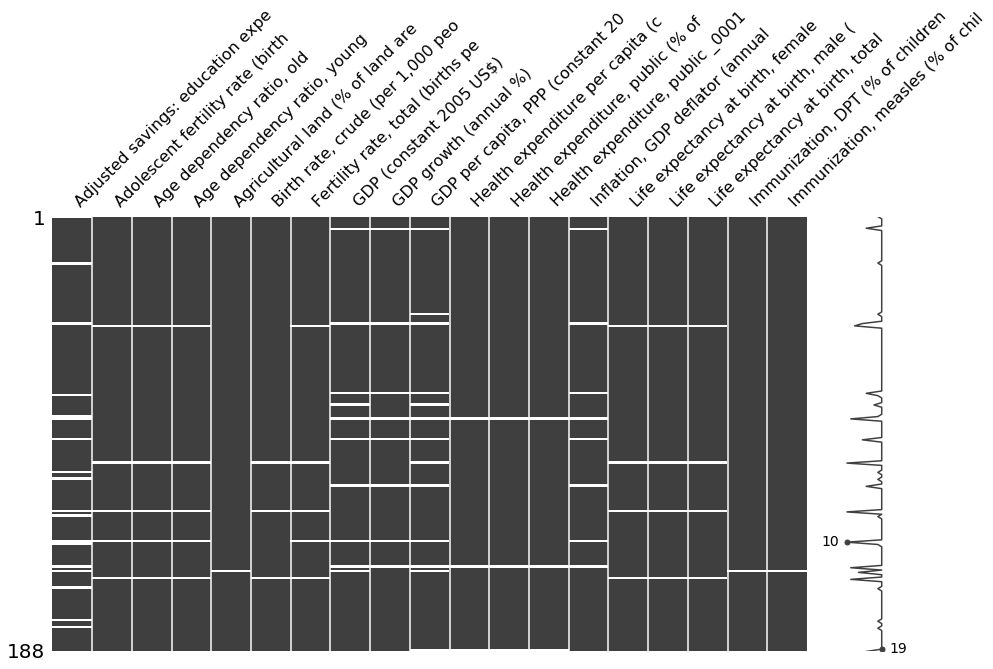

In [10]:
try:
    import missingno as msno
except ModuleNotFoundError as no_missingno:
    print(no_missingno)
    assert CURRENT_OS == "linux", "You are neither on Colab or have fancyimpute installed!!!"
    print("Now installing missingno")
    !pip install -q missingno 
    print("Installed!")
    from missingno import msno
finally:
    missingdata_df = world_bank.columns[world_bank.isnull().any()].tolist()
    msno.matrix(world_bank[missingdata_df], figsize=(15,8))

A correlation heatmap is shown below. This map describes the degree of nullity relationship between predictors. The range of this nullity correlation is from -1 to 1 (-1 ≤ R ≤ 1). Features with no missing value are excluded in the heatmap. If the nullity correlation is very close to zero (-0.05 < R < 0.05), no value will be displayed. Also, a perfect positive nullity correlation (R=1) indicates when the first feature and the second feature both have corresponding missing values while a perfect negative nullity correlation (R=-1) means that one of the features is missing and the second is not missing.

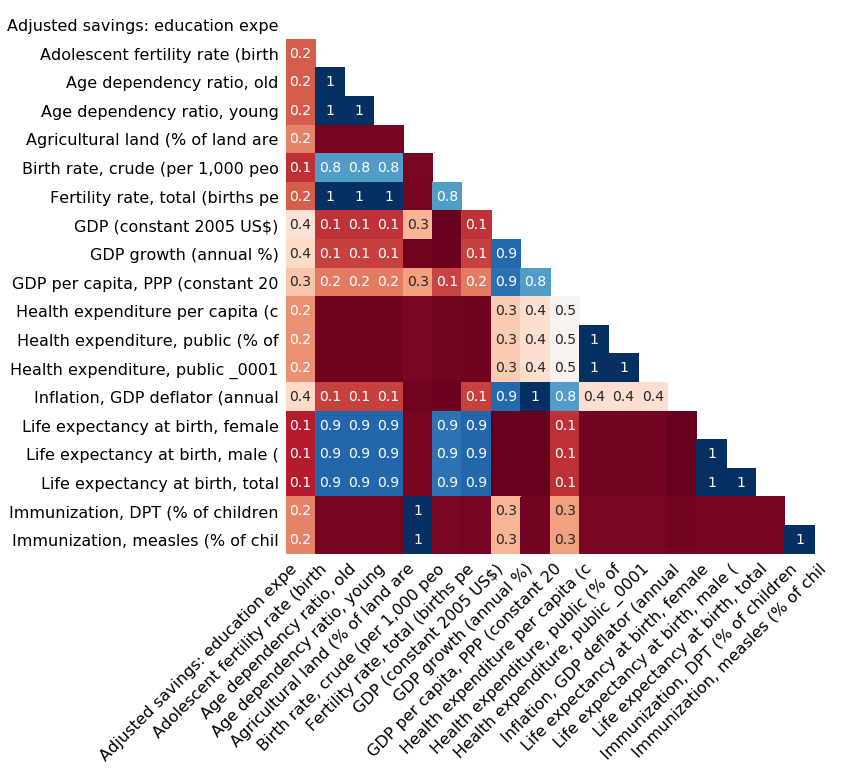

In [11]:
msno.heatmap(world_bank[missingdata_df], figsize=(10,10))

## Multiple Imputation by Chained Equations (MICE)

- Read the following articles,
  1. [Multiple Imputation by Chained Equations: What is it and how does it work?](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074241/) 
  1. [Missing Data Conundrum: Exploration and Imputation Techniques](https://medium.com/ibm-data-science-experience/missing-data-conundrum-exploration-and-imputation-techniques-9f40abe0fd87) 
  1. [Handling Missing Values in Machine Learning: Part 2](https://towardsdatascience.com/handling-missing-values-in-machine-learning-part-2-222154b4b58e)
  1. [fancyimpute](https://github.com/iskandr/fancyimpute)

- The draw backs of some other imputation techniques that we aren't using (e.g. mean)
- What is MICE, what is it trying to achieve
- How does MICE work?
- In what way does MICE outperform other techniques
- Does MICE rely on any assumptions (e.g. missing data are Missing at Random (MAR)好似係，除非唔係)

In [12]:
try:
    from fancyimpute import IterativeImputer
except ModuleNotFoundError as no_fancyimpute:
    print(ModuleNotFoundError)
    assert CURRENT_OS == "linux", "You are neither on Colab or have fancyimpute installed!!!"
    print("Now installing fancyimpute")
    !pip install -q fancyimpute 
    from fancyimpute import IterativeImputer
finally: 
    XY_incomplete = world_bank.copy()

    #fancy impute removes column names.
    train_cols = list(XY_incomplete)

    n_imputations = 5 #I wanted to use STAT5102 here, but looping 5102 times takes wayyyyyy too long.
    XY_completed = []
    for i in range(n_imputations):
        imputer = IterativeImputer(n_iter=5, sample_posterior=True, random_state=i)
        XY_completed.append(imputer.fit_transform(XY_incomplete))

    XY_completed_mean = np.mean(XY_completed, 0)
    XY_completed_std = np.std(XY_completed, 0)

    worldbank_imputed = pd.DataFrame(XY_completed_mean)
    worldbank_imputed.columns = train_cols
    assert not(worldbank_imputed.isnull().values.any())

Using TensorFlow backend.


# Exploratory Data Analysis

---

## Correlation heatmap

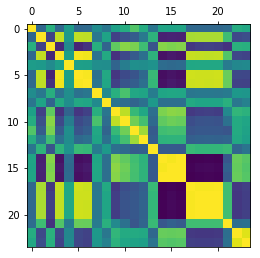

In [13]:
corr = worldbank_imputed.corr()
plt.matshow(worldbank_imputed.corr())

## Coefficient of Variation

Compare spread of each numeric variables

What is this part for ????

In [14]:
np.std(worldbank_imputed)/np.mean(worldbank_imputed)

Adjusted savings: education expe    0.431773
Adolescent fertility rate (birth    0.820008
Age dependency ratio, old           0.641521
Age dependency ratio, young         0.476919
Agricultural land (% of land are    0.555980
Birth rate, crude (per 1,000 peo    0.478226
Fertility rate, total (births pe    0.504724
GDP (constant 2005 US$)             3.901437
GDP growth (annual %)               0.928534
GDP per capita, PPP (constant 20    1.108000
Health expenditure per capita (c    1.746308
Health expenditure, public (% of    0.587757
Health expenditure, public _0001    0.396292
Inflation, GDP deflator (annual     1.069902
Life expectancy at birth, female    0.140021
Life expectancy at birth, male (    0.130872
Life expectancy at birth, total     0.134706
Mortality rate, infant (per 1,00    0.921152
Mortality rate, under-5 (per 1,0    1.051576
Mortality rate, under-5, female     1.076898
Mortality rate, under-5, male (p    1.031345
Population growth (annual %)        0.957492
Immunizati

Some variables shows extreme variation. e.g. GDP (constant 2005 US$) 

## Plotting distributions of numeric variables

我都唔係好知做呢part做乜@@


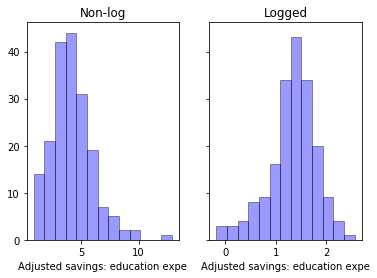

In [15]:
plot_data = worldbank_imputed["Adjusted savings: education expe"].copy()
plot_data_log = plot_data.apply(np.log)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
ax1.set_title("Non-log")
ax2.set_title("Logged")

plot_1 = sns.distplot(plot_data, hist=True, kde=False,
                      bins=int(plot_data.shape[0]**.5), 
                      color = 'blue',
                      hist_kws={'edgecolor':'black'},
                      ax=ax1)

plot_2 = sns.distplot(plot_data_log, hist=True, kde=False,
                      bins=int(plot_data_log.shape[0]**.5), 
                      color = 'blue',
                      hist_kws={'edgecolor':'black'},
                      ax=ax2)

# Exploring correlations with OLS regression

Not all variables are useful in the dataset. Some might be highly correlated with each other and thus create redundency and colinearity/multicolinearity.

Let's start by looking at the response variable, i.e. the Mortality rates

In [16]:
mortality_rates = list(worldbank_imputed.columns)
mortality_rates = [item for item in mortality_rates if item.startswith('Mortality')]
corr = worldbank_imputed[mortality_rates].corr()
corr.style.background_gradient(low=.9)

,"Mortality rate, infant (per 1,00","Mortality rate, under-5 (per 1,0","Mortality rate, under-5, female","Mortality rate, under-5, male (p"
"Mortality rate, infant (per 1,00",1,0.984823,0.982466,0.986222
"Mortality rate, under-5 (per 1,0",0.984823,1,0.999566,0.99968
"Mortality rate, under-5, female",0.982466,0.999566,1,0.998505
"Mortality rate, under-5, male (p",0.986222,0.99968,0.998505,1


We see that everything is highly corrrelated; they are essentially the same measure. Highly correlated predictors can lead to instability in our estimator, as well as increased variance. 

Not only do these variables covary, their vaule are also extremely close to each other. It is very tempting for us to just use a single one of these variables to predict our response variable. Let's do this and see what's gonna happen if we just pick one of these predictors to predict Mortality rate, under-5 (per 1,000 births)? Here we use Mortality rate, infant (per 1,000 births).

In [17]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(worldbank_imputed["Mortality rate, infant (per 1,00"].values, 
                                                    worldbank_imputed["Mortality rate, under-5 (per 1,0"].values, 
                                                    test_size=0.2, 
                                                    random_state = STAT5102)

X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

lm = linear_model.LinearRegression()
lm.fit(X_train, y_train)
fitted_values = lm.predict(X_test)
residuals = y_test - fitted_values
residuals = residuals.flatten()
residuals2 = np.sort(residuals)[:-1]

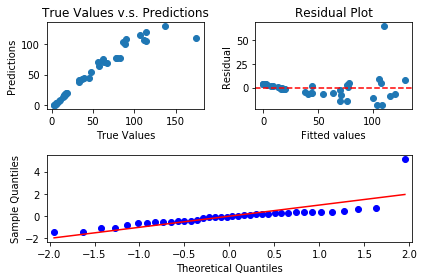

'Test R^2: 0.9135548398062148'

In [18]:
fig = plt.figure()
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(212)

ax1.scatter(y_test, fitted_values)
ax1.set_xlabel("True Values")
ax1.set_ylabel("Predictions")
ax1.set_title("True Values v.s. Predictions")

ax2.scatter(fitted_values, residuals)
ax2.axhline(y = 0, color='r', linestyle = '--')
ax2.set_xlabel("Fitted values")
ax2.set_ylabel("Residual")
ax2.set_title("Residual Plot")

import statsmodels.api as sm
sm.qqplot(residuals, line='s', ax=ax3, fit=True)

plt.tight_layout()
plt.show()

"Test R^2: " + str(lm.score(X = X_test, y = y_test))

### Normality Test

The residual plot is showing some mild fan shape pattern: the error does not remain constant along with the fitted values. This suggests either heteroscedasticity and/or nonlinear relationship between predictor and outcome. Let's perform a normality test for more percise asumption checking.

In [19]:
from scipy.stats import shapiro

# normality test
stat, p = shapiro(residuals)
print(f'Statistics={stat:.5}, p={p:.5}')
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.6543, p=3.2758e-08
Sample does not look Gaussian (reject H0)


In [20]:
from scipy.stats import kstest

stat, p = kstest(residuals, 'norm')
print(f'Statistics={stat:.5}, p={p:.5}')
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.40022, p=5.2537e-06
Sample does not look Gaussian (reject H0)


In [21]:
from scipy.stats import anderson

result = anderson(residuals, dist='norm')
print(f'Statistic: {result.statistic}')
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic.any() < result.critical_values[i]:
        print(f'Alpha at {sl/100}; Critical Value is:  {cv}, data looks Gaussian (fail to reject H0)')
    else:
        print(f'Alpha at {sl/100}; Critical Value is:  {cv}, data does not look Gaussian (reject H0)')

Statistic: 2.9116464441694276
Alpha at 0.15; Critical Value is:  0.529, data does not look Gaussian (reject H0)
Alpha at 0.1; Critical Value is:  0.603, data does not look Gaussian (reject H0)
Alpha at 0.05; Critical Value is:  0.723, data does not look Gaussian (reject H0)
Alpha at 0.025; Critical Value is:  0.844, data does not look Gaussian (reject H0)
Alpha at 0.01; Critical Value is:  1.004, data looks Gaussian (fail to reject H0)


### Heteroskedasticity test

In [22]:
from statsmodels.stats.diagnostic import het_breuschpagan
lm, lm_pvalue, fvalue, f_pvalue = het_breuschpagan(residuals, fitted_values)
print(f'F-Statistics = {fvalue:.5}, p = {f_pvalue:.5}')
alpha = 0.05
if p > alpha:
    print('Variance looks constant (fail to reject H0)')
else:
    print('Variance does not look constant (reject H0)')

F-Statistics = 5.5981, p = 0.023329
Variance does not look constant (reject H0)


Only under alpha level 0.01 in the Anderson-Darling test do we fail the reject the Normality assumption. 

The bottom line is, we cannot use Simple Linear Regression (OLS) simply because high correlation between predictor and outcome. We will not further investigate OLS in this report. 

How about the other two mortality indicators? After some eyeball investigation, it is not difficult to see that our response variable is merely the average of Male/Female mortality rate. Hence we will not include these two into our analysis because they are essentially the same thing as our response variable; they should not be included in any formal analysis because one could argue that this is a form of data leakage. However, it might be interesting to see how the DIFFERENCE in Male/Female mortality rate affects our response variable. Therefore we can consider adding the DIFFERENCE in Male/Female mortality rate into our dataset.

Finally, because of the following:
- infant mortality rate is highly correlated to our response
- they are measured in the same unit
- almost no difference in absolute value
- domain knowledge tell us that they are indeed almost the same measure

we decide to remove infant mortality rate.

In [23]:
Mortality_gender_diff = (worldbank_imputed["Mortality rate, under-5, male (p"] -
                         worldbank_imputed["Mortality rate, under-5, female"])
#add gender difference
worldbank_imputed.insert(21, "Mortality rate, under-5, Gender Difference", Mortality_gender_diff) 
#remove mortality rate for male and female
worldbank_imputed.drop(["Mortality rate, under-5, male (p", "Mortality rate, under-5, female"], axis=1,inplace=True)
#remove infant mortality rate
worldbank_imputed.drop(["Mortality rate, infant (per 1,00"], axis = 1, inplace = True)


In [24]:
#do the same thing for Life expectancy 
Life_expt_gender_diff = (worldbank_imputed["Life expectancy at birth, female"] -
                         worldbank_imputed["Life expectancy at birth, male ("])
#add gender difference
worldbank_imputed.insert(16, "Life expectancy at birth, Gender Difference", Life_expt_gender_diff) 
#remove Life expectency for male and female
worldbank_imputed.drop(["Life expectancy at birth, female", "Life expectancy at birth, male ("], axis=1,inplace=True)

In [25]:
#export world_bank to excel file to share with groupmates (19 Nov 2018)
share = 0
if share:
    writer = pd.ExcelWriter('worldbank_imputed.xlsx')
    worldbank_imputed.to_excel(writer, 'Sheet1')
    writer.save()

In [26]:
#!pip install -q openpyxl

In [27]:
#Remove outliner

# Multiple Regression

Perhapes a set of predictor variables can better explain the variations in Mortality rate?

In [28]:
multi_reg_data = worldbank_imputed.copy()
X_train, X_test, y_train, y_test = train_test_split(multi_reg_data.drop("Mortality rate, under-5 (per 1,0", axis=1), 
                                                    multi_reg_data["Mortality rate, under-5 (per 1,0"].values, 
                                                    test_size=0.2, 
                                                    random_state = STAT5102)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

lm = linear_model.LinearRegression()
lm.fit(X_train, y_train)
fitted_values = lm.predict(X_test)
residuals = y_test - fitted_values
residuals = residuals.flatten()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2a8c5e80>]],
      dtype=object)

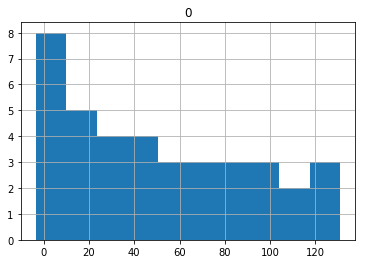

In [29]:
pd.DataFrame(fitted_values).hist()

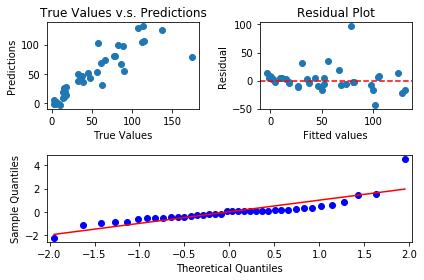

'Test R^2: 0.7682873054946006'

In [30]:
fig = plt.figure()
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(212)

ax1.scatter(y_test, fitted_values)
ax1.set_xlabel("True Values")
ax1.set_ylabel("Predictions")
ax1.set_title("True Values v.s. Predictions")

ax2.scatter(fitted_values, residuals)
ax2.axhline(y = 0, color='r', linestyle = '--')
ax2.set_xlabel("Fitted values")
ax2.set_ylabel("Residual")
ax2.set_title("Residual Plot")

sm.qqplot(residuals, line='s', ax=ax3, fit=True)

plt.tight_layout()
plt.show()

"Test R^2: " + str(lm.score(X = X_test, y = y_test))

### Normality Tests

In [31]:
stat, p = shapiro(residuals)
print(f'Statistics={stat:.5}, p={p:.5}')
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.7726, p=3.0289e-06
Sample does not look Gaussian (reject H0)


In [32]:
stat, p = kstest(residuals, 'norm')
print(f'Statistics={stat:.5}, p={p:.5}')
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.52325, p=3.2575e-10
Sample does not look Gaussian (reject H0)


In [33]:
result = anderson(residuals, dist='norm')
print(f'Statistic: {result.statistic}')
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic.any() < result.critical_values[i]:
        print(f'Alpha at {sl/100}: Critical Value is: {cv}, data looks Gaussian (fail to reject H0)')
    else:
        print(f'Alpha at {sl/100}; Critical Value is: {cv}, data does not look Gaussian (reject H0)')

Statistic: 2.3183948134127235
Alpha at 0.15; Critical Value is: 0.529, data does not look Gaussian (reject H0)
Alpha at 0.1; Critical Value is: 0.603, data does not look Gaussian (reject H0)
Alpha at 0.05; Critical Value is: 0.723, data does not look Gaussian (reject H0)
Alpha at 0.025; Critical Value is: 0.844, data does not look Gaussian (reject H0)
Alpha at 0.01: Critical Value is: 1.004, data looks Gaussian (fail to reject H0)


Other than setting alpha at 0.01 in an Anderson-Darling test, every other tests yields result suggesting non-normality in the residuals. 

### Heteroskedasticity test


In [34]:
lm, lm_pvalue, fvalue, f_pvalue = het_breuschpagan(residuals, fitted_values)
print(f'F-Statistics = {fvalue:.5}, p = {f_pvalue:.5}')
alpha = 0.05
if p > alpha:
    print('Variance looks constant (fail to reject H0)')
else:
    print('Variance does not look constant (reject H0)')

F-Statistics = 4.4519, p = 0.041685
Variance does not look constant (reject H0)


We have to consider transforming our data. 

# Regression Model

---

The work above are of exploratory nature. We found that both OLS and multiple regression result in residuals that are both heteroskedastic and non Gaussian. We must perform transformation.

The following is our current regression model:

\begin{equation}
Y = \beta_0 + \beta_1 X_1 + ... + \beta_p X_p + \epsilon
\end{equation}

where 

\begin{equation}
\epsilon \sim N(\mu,\sigma^2)
\end{equation}

We are regressing a continous variable Y on a set of Xs. The model assumes Y to be the sum of all Xs multiplied by their corrosponding coefficients, plus random normal error. This model works well if we can plug in numbers on the Right Hand Side(RHS) and get the corrosponding value on the Left Hand Side (LHS). The regression model shown above relies heavily on two assumptions:

- Constant Error terms
- Gaussian in Error terms
- LHS of the model be strictly positive.

We have already concluded we failed to obtain constant and Gaussian error terms.

Note that the sum on the RHS can sometimes be negative depending on the input and coefficients. Unfortunately, our response variable, Mortality rate, under-5 (per 1,000 births), can not take negative values; our model is broken when ever the sum on of the RHS comes out negative. 

Because of this, we perform a log transformation on the response variable. 

\begin{equation}
\log(Y) = \beta_0 + \beta_1 X_1 + ... + \beta_p X_p + \epsilon
\end{equation}

With a log transformation on the response variable, values on both sides of the equation may take negative values, and we are no longer restricted by the fact that the response can only take positive values. **呢part寫多兩句**.....

To confirm our choice of transformation, we perform a Box-Cox power transformation, and find the lambda parameter that maximises the log-likelihood function.

In [35]:
boxcox_lambda = scipy.stats.boxcox(worldbank_imputed["Mortality rate, under-5 (per 1,0"].copy())[1]
print("The lambda parameter that maximises the log-likelihood function is: ", boxcox_lambda)

The lambda parameter that maximises the log-likelihood function is:  0.011172997239718391


Choosing a simple power transformation, we come to the conclusion that log transformation will best transform our data to normality.

In [36]:
#worldbank_imputed["Mortality rate, under-5 (per 1,0"] = worldbank_imputed["Mortality rate, under-5 (per 1,0"].apply(np.log)

# Multiple Regression with transformed response variable
---

let's do this again.

In [37]:
log_multi_reg_data = worldbank_imputed.copy()
log_multi_reg_data["Mortality rate, under-5 (per 1,0"] = log_multi_reg_data["Mortality rate, under-5 (per 1,0"].apply(np.log)
X_train, X_test, y_train, y_test = train_test_split(log_multi_reg_data.drop("Mortality rate, under-5 (per 1,0", axis=1), 
                                                    log_multi_reg_data["Mortality rate, under-5 (per 1,0"].values, 
                                                    test_size=0.2, 
                                                    random_state = STAT5102)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

lm = linear_model.LinearRegression()
lm.fit(X_train, y_train)
fitted_values = lm.predict(X_test)
residuals = y_test - fitted_values
residuals = residuals.flatten()

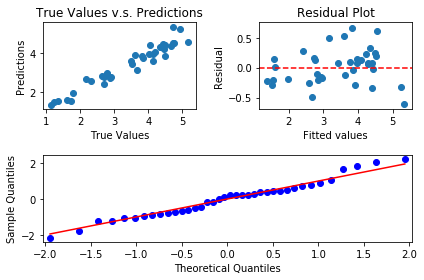

'Test R^2: 0.9374485589812057'

In [38]:
fig = plt.figure()
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(212)

ax1.scatter(y_test, fitted_values)
ax1.set_xlabel("True Values")
ax1.set_ylabel("Predictions")
ax1.set_title("True Values v.s. Predictions")

ax2.scatter(fitted_values, residuals)
ax2.axhline(y = 0, color='r', linestyle = '--')
ax2.set_xlabel("Fitted values")
ax2.set_ylabel("Residual")
ax2.set_title("Residual Plot")

sm.qqplot(residuals, line='s', ax=ax3, fit=True)

plt.tight_layout()
plt.show()

"Test R^2: " + str(lm.score(X = X_test, y = y_test))

### Normality Tests

In [39]:
stat, p = shapiro(residuals)
print(f'Statistics={stat:.5}, p={p:.5}')
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.97867, p=0.67029
Sample looks Gaussian (fail to reject H0)


In [40]:
stat, p = kstest(residuals, 'norm')
print(f'Statistics={stat:.5}, p={p:.5}')
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.31418, p=0.00078373
Sample does not look Gaussian (reject H0)


In [41]:
result = anderson(residuals, dist='norm')
print(f'Statistic: {result.statistic}')
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic.any() < result.critical_values[i]:
        print(f'Alpha at {sl/100}: Critical Value is: {cv}, data looks Gaussian (fail to reject H0)')
    else:
        print(f'Alpha at {sl/100}; Critical Value is: {cv}, data does not look Gaussian (reject H0)')

Statistic: 0.32387781486233536
Alpha at 0.15; Critical Value is: 0.529, data does not look Gaussian (reject H0)
Alpha at 0.1; Critical Value is: 0.603, data does not look Gaussian (reject H0)
Alpha at 0.05; Critical Value is: 0.723, data does not look Gaussian (reject H0)
Alpha at 0.025; Critical Value is: 0.844, data does not look Gaussian (reject H0)
Alpha at 0.01: Critical Value is: 1.004, data looks Gaussian (fail to reject H0)


### Heteroskedasticity test

In [42]:
lm, lm_pvalue, fvalue, f_pvalue = het_breuschpagan(residuals, fitted_values)
print(f'F-Statistics = {fvalue:.5}, p = {f_pvalue:.5}')
alpha = 0.05
if p > alpha:
    print('Variance looks constant (fail to reject H0)')
else:
    print('Variance does not look constant (reject H0)')

F-Statistics = 22.996, p = 2.6493e-05
Variance does not look constant (reject H0)


# FUCK.....

# Lasso Regression

---


There are relatively few countries around the world compared to the amount of data we generate. After some initial wrangling, we only have 192 countries remaining in our dataset, with 26 first order predictors (and 300 if we consider interaction and second order terms!). Low number of observations put us at risk of overfitting the data, which inflates the variance of our model. Feature selection is therefore needed so we won't be using all 26 predictors (or 300). Also, from the correlation matrix presented above, we know that some predictors are highly correlated and are almot linearly dependent. Hence, we are not at risk of increasing bias if we know which ones to throw away.

The Lasso regulisation impose a L1 penalty on the coefficients: every coefficient is being shrinked, and some even as low as zero. This is practically equal to feature selection since feature with zero coefficient has no effect in the model.  

Tony話其實啲人會一開始就做咗Lasso先，咁就當做咗Feature Selection。
我諗緊:
- Lasso -> Best Subset 
- Best Subset -> Lasso
- 唔做Lasso (因為Best Subset 已經夠?)

In [43]:
from sklearn.linear_model import Lasso

#呢到Y冇log
lasso_data = worldbank_imputed.copy()


#dummies = pd.get_dummies(lasso_data["Continent"])
y = lasso_data["Mortality rate, under-5 (per 1,0"]
# Drop Salary (target) and columns for which we created dummy variables
#X_ = lasso_data.drop(["Mortality rate, under-5 (per 1,0", "Continent"], axis=1)
X = lasso_data.drop(["Mortality rate, under-5 (per 1,0"], axis=1)
# Define the feature set X.
# dummies = pd.get_dummies(lasso_data["Continent"])
# X = pd.concat([X_, dummies], axis=1)

In [44]:
alphas = np.logspace(3, -2, 50)*0.5
lasso = Lasso(max_iter=10000, normalize=True, random_state = STAT5102)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X, y)
    coefs.append(lasso.coef_)
    
np.shape(coefs)

(50, 20)

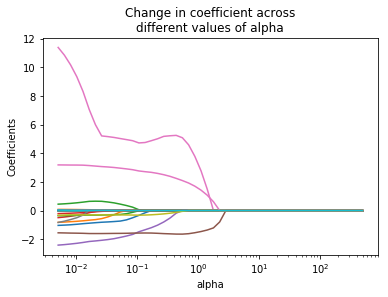

In [45]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coefficients')
plt.title("Change in coefficient across\ndifferent values of alpha")
plt.show()

In [46]:
# Use the cross-validation package to split data into training and test sets
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = STAT5102)

lassocv = LassoCV(alphas=None, cv=5, max_iter=100000, normalize=True, random_state = STAT5102)
lassocv.fit(X_train, y_train)

lasso.set_params(alpha=lassocv.alpha_)
print("Alpha=", lassocv.alpha_)
lasso.fit(X_train, y_train)
print("mse = ", mean_squared_error(y_test, lasso.predict(X_test)))
print("best model coefficients:")
L1_predictors = pd.Series(lasso.coef_.round(10), index=X.columns)
L1_predictors = L1_predictors[L1_predictors != 0.0]
L1_predictors

Alpha= 0.011017890890817797
mse =  425.62917387321505
best model coefficients:


Adjusted savings: education expe              -0.090298
Adolescent fertility rate (birth               0.128999
Age dependency ratio, old                      0.529734
Age dependency ratio, young                   -0.322445
Agricultural land (% of land are              -0.024502
Fertility rate, total (births pe               9.882133
GDP growth (annual %)                          0.442632
GDP per capita, PPP (constant 20               0.000065
Health expenditure per capita (c               0.001117
Health expenditure, public (% of              -0.884620
Health expenditure, public _0001              -0.276396
Inflation, GDP deflator (annual                0.110962
Life expectancy at birth, Gender Difference   -2.286172
Life expectancy at birth, total               -2.063115
Mortality rate, under-5, Gender Difference     2.091391
Population growth (annual %)                  -1.854629
Immunization, DPT (% of children              -0.163757
dtype: float64

18 variables left

# Best Subset Selection

In [48]:
from sklearn.metrics import mean_squared_error
def fit_linear_reg(X,Y):
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        Y,
                                                        test_size=0.2,
                                                        random_state = STAT5102)

    #Fit linear regression model and return RSS and R squared values
    model_k = linear_model.LinearRegression(fit_intercept = True, n_jobs=3)
    model_k.fit(X_train, y_train)

    #get test RSS
    fitted_values = model_k.predict(X_test)
    RSS = mean_squared_error(y_test, fitted_values) * len(y_test)
    
    #get test R^2
    R_squared = model_k.score(X_test,y_test)
    n = X_test.shape[0]
    k = X_test.shape[1]
    adj_R_squared = 1-(1-R_squared)*(n-1)/(n-k-1)    

    #returning the test RSS and test R^2
    return RSS, adj_R_squared 

In [68]:
for combo in itertools.combinations(best_subset_data[L1_predictors.index].columns,10):
    print(combo)

('Adjusted savings: education expe', 'Adolescent fertility rate (birth', 'Age dependency ratio, old', 'Age dependency ratio, young', 'Agricultural land (% of land are', 'Fertility rate, total (births pe', 'GDP growth (annual %)', 'GDP per capita, PPP (constant 20', 'Health expenditure per capita (c', 'Health expenditure, public (% of')
('Adjusted savings: education expe', 'Adolescent fertility rate (birth', 'Age dependency ratio, old', 'Age dependency ratio, young', 'Agricultural land (% of land are', 'Fertility rate, total (births pe', 'GDP growth (annual %)', 'GDP per capita, PPP (constant 20', 'Health expenditure per capita (c', 'Health expenditure, public _0001')
('Adjusted savings: education expe', 'Adolescent fertility rate (birth', 'Age dependency ratio, old', 'Age dependency ratio, young', 'Agricultural land (% of land are', 'Fertility rate, total (births pe', 'GDP growth (annual %)', 'GDP per capita, PPP (constant 20', 'Health expenditure per capita (c', 'Inflation, GDP deflat

('Adjusted savings: education expe', 'Adolescent fertility rate (birth', 'Age dependency ratio, old', 'Agricultural land (% of land are', 'Fertility rate, total (births pe', 'GDP growth (annual %)', 'Health expenditure, public (% of', 'Inflation, GDP deflator (annual', 'Life expectancy at birth, total', 'Immunization, DPT (% of children')
('Adjusted savings: education expe', 'Adolescent fertility rate (birth', 'Age dependency ratio, old', 'Agricultural land (% of land are', 'Fertility rate, total (births pe', 'GDP growth (annual %)', 'Health expenditure, public (% of', 'Inflation, GDP deflator (annual', 'Mortality rate, under-5, Gender Difference', 'Population growth (annual %)')
('Adjusted savings: education expe', 'Adolescent fertility rate (birth', 'Age dependency ratio, old', 'Agricultural land (% of land are', 'Fertility rate, total (births pe', 'GDP growth (annual %)', 'Health expenditure, public (% of', 'Inflation, GDP deflator (annual', 'Mortality rate, under-5, Gender Differen

('Adjusted savings: education expe', 'Adolescent fertility rate (birth', 'Age dependency ratio, young', 'Agricultural land (% of land are', 'Fertility rate, total (births pe', 'GDP per capita, PPP (constant 20', 'Health expenditure per capita (c', 'Health expenditure, public _0001', 'Population growth (annual %)', 'Immunization, DPT (% of children')
('Adjusted savings: education expe', 'Adolescent fertility rate (birth', 'Age dependency ratio, young', 'Agricultural land (% of land are', 'Fertility rate, total (births pe', 'GDP per capita, PPP (constant 20', 'Health expenditure per capita (c', 'Inflation, GDP deflator (annual', 'Life expectancy at birth, Gender Difference', 'Life expectancy at birth, total')
('Adjusted savings: education expe', 'Adolescent fertility rate (birth', 'Age dependency ratio, young', 'Agricultural land (% of land are', 'Fertility rate, total (births pe', 'GDP per capita, PPP (constant 20', 'Health expenditure per capita (c', 'Inflation, GDP deflator (annual', 

('Adjusted savings: education expe', 'Adolescent fertility rate (birth', 'Agricultural land (% of land are', 'Fertility rate, total (births pe', 'GDP growth (annual %)', 'Health expenditure, public (% of', 'Life expectancy at birth, Gender Difference', 'Life expectancy at birth, total', 'Population growth (annual %)', 'Immunization, DPT (% of children')
('Adjusted savings: education expe', 'Adolescent fertility rate (birth', 'Agricultural land (% of land are', 'Fertility rate, total (births pe', 'GDP growth (annual %)', 'Health expenditure, public (% of', 'Life expectancy at birth, Gender Difference', 'Mortality rate, under-5, Gender Difference', 'Population growth (annual %)', 'Immunization, DPT (% of children')
('Adjusted savings: education expe', 'Adolescent fertility rate (birth', 'Agricultural land (% of land are', 'Fertility rate, total (births pe', 'GDP growth (annual %)', 'Health expenditure, public (% of', 'Life expectancy at birth, total', 'Mortality rate, under-5, Gender Dif

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [49]:
print("start")
#Importing tqdm for the progress bar
from tqdm import tnrange, tqdm_notebook
import itertools

#Initialization variables
best_subset_data = worldbank_imputed.copy()

#X = best_subset_data.drop("Mortality rate, under-5 (per 1,0", axis=1)

X = best_subset_data[L1_predictors.index]
Y = best_subset_data["Mortality rate, under-5 (per 1,0"]

RSS_list, adj_R_squared_list, feature_list = [],[], []
numb_features = []

#Looping over k = 1 to k = 11 features in X
for k in tnrange(1,len(X.columns) + 1, desc = 'Loop...'):
#for k in range(1,len(X.columns) + 1):
    print("Now working on ", k, " features!")
    #Looping over all possible combinations: from 11 choose k
    for combo in itertools.combinations(X.columns,k):
        tmp_result = fit_linear_reg(X[list(combo)],Y)   #Store temp result 
        RSS_list.append(tmp_result[0])                  #Append lists
        adj_R_squared_list.append(tmp_result[1])
        
        feature_list.append(combo)
        numb_features.append(len(combo))   

#Store in DataFrame
best_sub_features = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list, 'Adj_R_squared':adj_R_squared_list,'features':feature_list})
print("Done!")


start


Now working on  1  features!
Now working on  2  features!
Now working on  3  features!
Now working on  4  features!
Now working on  5  features!
Now working on  6  features!
Now working on  7  features!
Now working on  8  features!
Now working on  9  features!
Now working on  10  features!
Now working on  11  features!
Now working on  12  features!
Now working on  13  features!
Now working on  14  features!
Now working on  15  features!
Now working on  16  features!
Now working on  17  features!

Done!


In [50]:
print("There are a total of", best_sub_features.shape[0], "subsets.")

There are a total of 131071 subsets.


There are numerous combinations for every number of features (e.g. 21 combinations when K == 1). 
We must select the 'best' subset out of 1048575 subsets. Hence, for every K (from 1 to 21),  we pick out the subset with smallest test RSS, then store it in a dataframe. We also pick out the subset with highest test adjusted $R^2$, and store them in another dataframe. 

In [51]:
min_RSS = best_sub_features[best_sub_features.groupby('numb_features')['RSS'].transform(min) == best_sub_features['RSS']]
max_adj_R2 = best_sub_features[best_sub_features.groupby('numb_features')['Adj_R_squared'].transform(max) == best_sub_features['Adj_R_squared']]
display(min_RSS.head(3))
display(max_adj_R2.head(3))


,numb_features,RSS,Adj_R_squared,features
14,1,15775.237865,0.771590,"(Mortality rate, under-5, Gender Difference,)"
144,2,12264.671184,0.817346,"(Life expectancy at birth, Gender Difference, ..."
827,3,10083.861322,0.845407,"(Life expectancy at birth, Gender Difference, ..."


,numb_features,RSS,Adj_R_squared,features
14,1,15775.237865,0.771590,"(Mortality rate, under-5, Gender Difference,)"
144,2,12264.671184,0.817346,"(Life expectancy at birth, Gender Difference, ..."
827,3,10083.861322,0.845407,"(Life expectancy at birth, Gender Difference, ..."


The two look very similar. If we compare the two dataframes

In [52]:
all(min_RSS == max_adj_R2)

True

We see that the two dataframes are identical. This tells us that for a given K (number of features), the subset with the lowest RSS is also the subset with the highest adjusted $R^2$. 

Next we sort the two data frames by adjusted  $R^2$ and RSS.

In [55]:
display(max_adj_R2.drop(['RSS'], axis = 1).sort_values(by=['Adj_R_squared'], ascending = False).head(7))
display(min_RSS.drop(['Adj_R_squared'], axis = 1).sort_values(by=['RSS'], ascending = True).head(7))

,numb_features,Adj_R_squared,features
18607,6,0.855810,"(Age dependency ratio, old, GDP per capita, PP..."
37686,7,0.852912,"(Age dependency ratio, old, GDP per capita, PP..."
7358,5,0.851755,"(Age dependency ratio, old, Health expenditure..."
61633,8,0.848925,"(Age dependency ratio, old, Agricultural land ..."
3172,4,0.847334,"(Health expenditure, public (% of, Life expect..."
827,3,0.845407,"(Life expectancy at birth, Gender Difference, ..."
87261,9,0.844349,"(Age dependency ratio, old, Agricultural land ..."


,numb_features,RSS,features
116048,11,8319.922865,"(Adjusted savings: education expe, Age depende..."
98701,10,8322.307093,"(Adjusted savings: education expe, Age depende..."
87261,9,8361.222804,"(Age dependency ratio, old, Agricultural land ..."
125565,12,8378.644896,"(Adjusted savings: education expe, Age depende..."
61633,8,8405.233035,"(Age dependency ratio, old, Agricultural land ..."
129566,13,8463.855488,"(Adjusted savings: education expe, Age depende..."
37686,7,8465.579184,"(Age dependency ratio, old, GDP per capita, PP..."


choose either 10 or 11.

In [96]:
best_subset_features = min_RSS[min_RSS["numb_features"] == 8]["features"].tolist()
best_subset_features = list(best_subset_features[0])
best_subset_features

['Age dependency ratio, old',
 'Agricultural land (% of land are',
 'GDP per capita, PPP (constant 20',
 'Health expenditure, public (% of',
 'Life expectancy at birth, Gender Difference',
 'Mortality rate, under-5, Gender Difference',
 'Population growth (annual %)',
 'Immunization, DPT (% of children']

## Plotting the best subset selection process

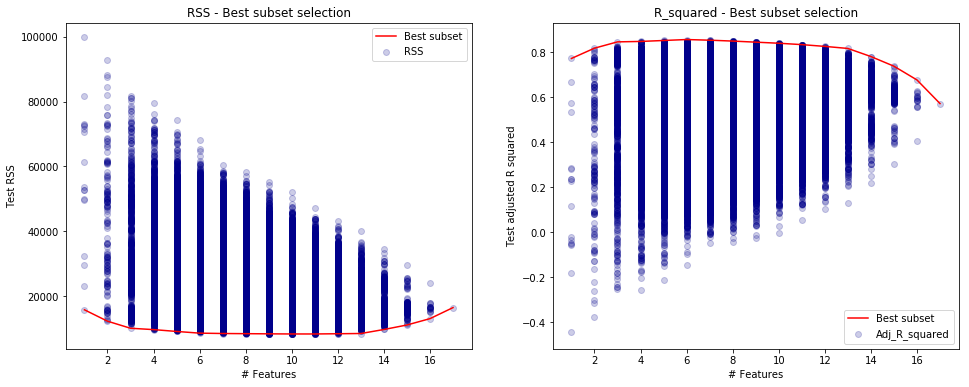

In [56]:
#Adding columns to the dataframe with RSS and R squared values of the best subset
best_sub_features['min_RSS'] = best_sub_features.groupby('numb_features')['RSS'].transform(min)
best_sub_features['max_R_squared'] = best_sub_features.groupby('numb_features')['Adj_R_squared'].transform(max)

fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(1, 2, 1)

ax.scatter(best_sub_features.numb_features,best_sub_features.RSS, alpha = .2, color = 'darkblue' )
ax.set_xlabel('# Features')
ax.set_ylabel('Test RSS')
ax.set_title('RSS - Best subset selection')
ax.plot(best_sub_features.numb_features, best_sub_features.min_RSS,color = 'r', label = 'Best subset')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.scatter(best_sub_features.numb_features,best_sub_features.Adj_R_squared, alpha = .2, color = 'darkblue' )
ax.plot(best_sub_features.numb_features,best_sub_features.max_R_squared,color = 'r', label = 'Best subset')
ax.set_xlabel('# Features')
ax.set_ylabel('Test adjusted R squared')
ax.set_title('R_squared - Best subset selection')
ax.legend()

plt.show()

# Multiple Regression

Use all first order terms

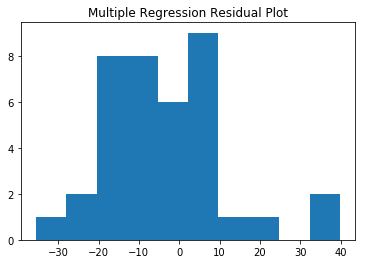

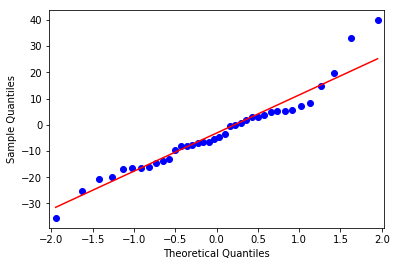

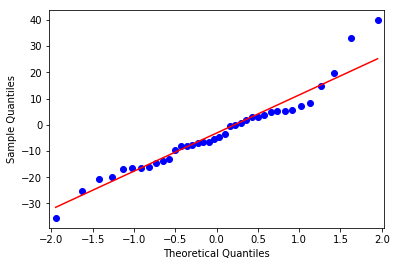

In [97]:

multi_reg_data = worldbank_imputed.copy()
X_train, X_test, y_train, y_test = train_test_split(multi_reg_data[best_subset_features], 
                                                    multi_reg_data["Mortality rate, under-5 (per 1,0"].values, 
                                                    test_size=0.2, 
                                                    random_state = STAT5102)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)
residuals = y_test - predictions
residuals = residuals.flatten()

plt.hist(residuals)
plt.title("Multiple Regression Residual Plot")
plt.show()

from statsmodels.graphics.gofplots import qqplot
qqplot(residuals, line='s')
#Do normality test

# Variance Inflation Factor

Multicollinearity occurs when two or more predictors in the model are correlated and provide redundant information about the response. Multicollinearity was measured by variance inflation factors (VIF) and tolerance. If VIF value exceeding 4.0, or by tol- erance less than 0.2 then there is a problem with multicollinearity (Hair et al., 2010).

做完Best Subset之後先用VIF黎check淨低果啲predictors

In [91]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]


In [98]:
# X = multi_reg_data.drop("Mortality rate, under-5 (per 1,0", axis=1)
X = multi_reg_data[best_subset_features]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif
#calculate_vif_(X)

,VIF Factor,features
0,12.303925,"Age dependency ratio, old"
1,5.151817,Agricultural land (% of land are
2,4.766450,"GDP per capita, PPP (constant 20"
3,6.768525,"Health expenditure, public (% of"
4,7.670171,"Life expectancy at birth, Gender Difference"
5,4.496314,"Mortality rate, under-5, Gender Difference"
6,4.616792,Population growth (annual %)
7,22.873441,"Immunization, DPT (% of children"


# Create polynomial features 

---

### See how many polynomial features can there be using the PolynomialFeatures function; to generate quadratic terms for Polynomial regression

In [0]:
from sklearn.preprocessing import PolynomialFeatures

#example
#test PolynomialFeatures function
data = pd.DataFrame.from_dict({
    'x': np.random.randint(low=1, high=10, size=5),
    'y': np.random.randint(low=-1, high=1, size=5),
})

p = PolynomialFeatures(degree=2).fit(data)
p.get_feature_names(data.columns)

['1', 'x', 'y', 'x^2', 'x y', 'y^2']

So a 2-D matrix becomes 5-D after adding second order terms and interaction terms. The transformed data is in the following matrix:

In [0]:
p.transform(data)

array([[ 1.,  6.,  0., 36.,  0.,  0.],
       [ 1.,  8., -1., 64., -8.,  1.],
       [ 1.,  3., -1.,  9., -3.,  1.],
       [ 1.,  8.,  0., 64.,  0.,  0.],
       [ 1.,  2.,  0.,  4.,  0.,  0.]])

### Transform our data

In [0]:
#make a copy of our dataset: dont mess with our dataset
#impute data with mean coz PolynomialFeatures function can't work with dataset with missing data
poly = worldbank_imputed.copy()
poly.drop(["Mortality rate, under-5 (per 1,0"], axis=1, inplace = True)

#have to deal with continent column.
degree = 2
quadratic_terms = PolynomialFeatures(degree = degree).fit(poly)
ternames = quadratic_terms.get_feature_names(poly.columns)
num_terms = len(ternames)

#transform data into their corrosponding quadratic form
quadratic_data = quadratic_terms.transform(poly)
quadratic_data = pd.DataFrame(data = quadratic_data)
quadratic_data.rename(columns=dict(zip(quadratic_data.columns,ternames)), inplace=True)
"There are a total of " + str(num_terms) + " first, second, and interaction terms"

'There are a total of 253 first, second, and interaction terms'

# Variance Inflation Factor on higher order terms

In [0]:
# vifed = calculate_vif_(quadratic_data, 5)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(quadratic_data.values, i) for i in range(quadratic_data.shape[1])]
vif["features"] = quadratic_data.columns
vif

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1386: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,VIF Factor,features
0,0.000000,1
1,0.220122,Adjusted savings: education expe
2,0.466649,Adolescent fertility rate (birth
3,0.490752,"Age dependency ratio, old"
4,0.226803,"Age dependency ratio, young"
5,0.327181,Agricultural land (% of land are
6,0.230299,"Birth rate, crude (per 1,000 peo"
7,0.250824,"Fertility rate, total (births pe"
8,85206.814389,GDP (constant 2005 US$)
9,0.625294,GDP growth (annual %)


# PCA on 1st order variables

In [0]:
from sklearn.preprocessing import StandardScaler


# Separating out the features
x = worldbank_imputed.copy().drop(["Mortality rate, under-5 (per 1,0"], axis=1)
#PCA cannot handle missing data
x = x.fillna(x.mean())
# Separating out the target
y = worldbank_imputed.copy()["Mortality rate, under-5 (per 1,0"].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

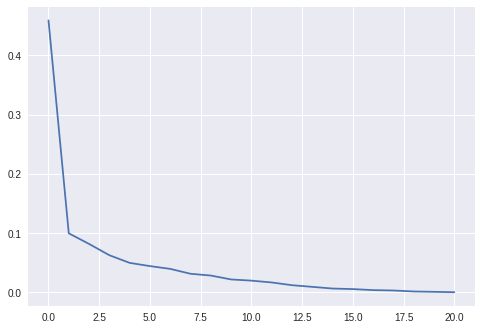

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=x.shape[1])
principalComponents = pca.fit_transform(x)
var = pca.explained_variance_ratio_
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
plt.plot(var)

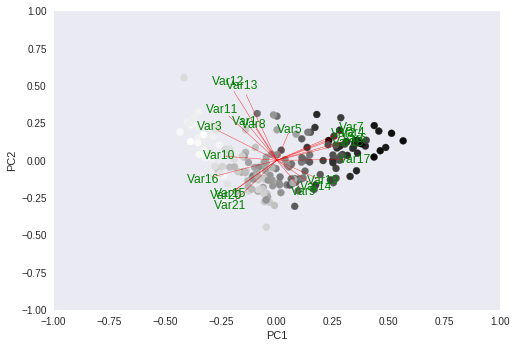

In [0]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. Use only the 2 PCs.
myplot(principalComponents[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

# PCA on 2nd order variables

In [0]:
from sklearn.preprocessing import StandardScaler
# Separating out the features
quadratic_x = quadratic_data
# Separating out the target
quadratic_y = world_bank_numeric["Mortality rate, under-5 (per 1,0"].values
# Standardizing the features
quadratic_x = StandardScaler().fit_transform(quadratic_x)

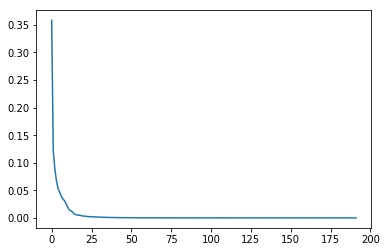

In [0]:
from sklearn.decomposition import PCA
quadratic_pca = PCA(n_components = quadratic_x.shape[1])
principalComponents = quadratic_pca.fit_transform(quadratic_x)
quadratic_var = quadratic_pca.explained_variance_ratio_
quadratic_var1 = np.cumsum(np.round(quadratic_var, decimals=4)*100)
plt.plot(quadratic_var)

In [0]:
variation_cutoff = 95
PC_count = len(quadratic_var1[quadratic_var1 < variation_cutoff])

(str(PC_count) + 
 " principle components (generated from 1st, 2nd, and interaction terms) are required to explain " +
 str(variation_cutoff) +
 "% of variation.")

'18 principle components (generated from 1st, 2nd, and interaction terms) are required to explain 95% of variation.'

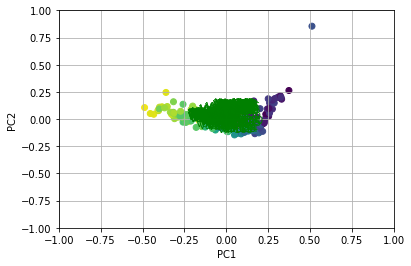

In [0]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. Use only the 2 PCs.
myplot(principalComponents[:,0:2],np.transpose(quadratic_pca.components_[0:2, :]))
plt.show()

In [0]:
quadratic_pca.components_.shape

(192, 210)

In [0]:
principalComponents.shape

(192, 192)